In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import time
import random
import json
import gc

import PIL
from PIL import Image

import numpy as np
import pandas as pd
import torch
import h5py
from ipywidgets import interact
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import nibabel as nib
from einops import rearrange
from scipy import ndimage, stats
from sklearn.neighbors import NearestNeighbors

dir2 = os.path.abspath('../..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)
    
from research.data.natural_scenes import NaturalScenesDataset
from research.experiments.nsd.nsd_access import NSDAccess
from research.metrics.metrics import cosine_distance, top_knn_test

In [2]:
nsd_path = Path('D:\\Datasets\\NSD\\')
nsd = NaturalScenesDataset(nsd_path, coco_path='X:\\Datasets\\COCO')

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

dataset_path = Path('D:\\Datasets\\NSD')
stimulu_path = dataset_path / 'nsddata_stimuli' / 'stimuli' / 'nsd' / 'nsd_stimuli.hdf5'
stimulus_images = h5py.File(stimulu_path, 'r')['imgBrick']

model_name = 'ViT-B=32'
stimulus_key = 'embedding'

stimulus_file = h5py.File(nsd_path / f'derivatives/stimulus_embeddings/{model_name}.hdf5', 'r')
x = stimulus_file[stimulus_key][:]

In [4]:
# Load a clip model
import clip

print(clip.available_models())
full_model, preprocess = clip.load('ViT-B/32', device=device)
model = full_model.visual

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


In [7]:
def get_stim_id(p: Path):
    return int(p.name.split('_')[1].split('-')[1])

def embed_reconstructions(reconstructions_path):
    reconstruction_files = [p for p in reconstructions_path.iterdir() if p.name != 'desktop.ini']
    reconstruction_files.sort(key=get_stim_id)
    stimulus_ids = np.array([get_stim_id(p) for p in reconstruction_files])
    unique_stimulus_ids = np.unique(stimulus_ids)

    x_recon_all = []
    for stim_id in unique_stimulus_ids:
        recon_ids = np.where(stimulus_ids == stim_id)[0]
        x_recon = []
        for recon_id in recon_ids:
            image = Image.open(reconstruction_files[recon_id]).resize((224, 224))
            with torch.no_grad():
                x_recon.append(model(preprocess(image).unsqueeze(0).to(device).to(torch.float16)))
        x_recon = torch.cat(x_recon).cpu().numpy()
        x_recon = x_recon / np.linalg.norm(x_recon, axis=1, keepdims=True)
        x_recon_all.append(x_recon)
    
    return {'x_recon': np.stack(x_recon_all), 'stimulus_ids': unique_stimulus_ids}


In [6]:
model_name = 'clip-vit-large-patch14-text'
group_name = 'group-5'

run_names = [f'run-003', 'run-004']
subjects = [f'subj0{i}' for i in range(1, 9)]

results = {run_name: {subject: {} for subject in subjects} for run_name in run_names}

for run_name in run_names:
    for subject in subjects:
        print(run_name, subject)
        reconstructions_path = nsd_path / f'derivatives/reconstructions/{model_name}/{group_name}/{run_name}/{subject}/images'
        results[run_name][subject] = embed_reconstructions(reconstructions_path)

run-003 subj01
run-003 subj02
run-003 subj03
run-003 subj04
run-003 subj05
run-003 subj06
run-003 subj07
run-003 subj08
run-004 subj01
run-004 subj02
run-004 subj03
run-004 subj04
run-004 subj05
run-004 subj06
run-004 subj07
run-004 subj08


In [10]:
results.keys()

dict_keys(['run-003', 'run-004'])

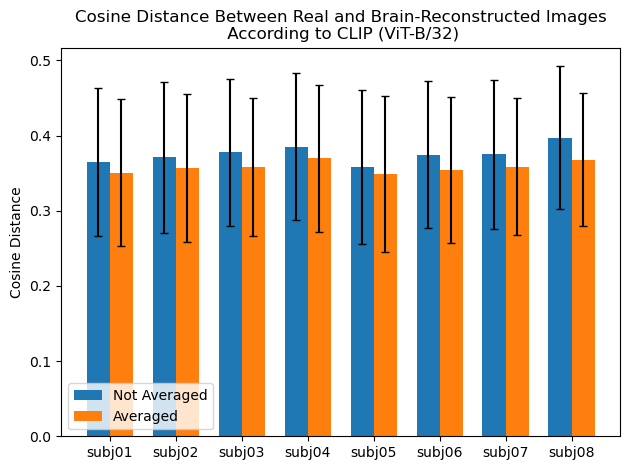

In [13]:
permutation_test = False
cosine_distance = {}
for run_name, subjects in results.items():
    cosine_distance[run_name] = {'mean': [], 'std': []}
    for subject, subject_data in subjects.items():
        x_recon = subject_data['x_recon']
        x_stim = x[subject_data['stimulus_ids']]
        if permutation_test:
            ids = np.arange(x_stim.shape[0])
            np.random.shuffle(ids)
            x_stim = x_stim[ids]
        
        cosine_dist = 1. - (x_recon * x_stim[:, None]).sum(axis=-1)
        cosine_distance[run_name]['mean'].append(cosine_dist.mean())
        cosine_distance[run_name]['std'].append(cosine_dist.std())

bar_pos = np.arange(8)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(bar_pos - width/2, cosine_distance['run-004']['mean'], 
                width, yerr=cosine_distance['run-004']['std'], label='Not Averaged',
               capsize=3)
rects2 = ax.bar(bar_pos + width/2, cosine_distance['run-003']['mean'], 
                width, yerr=cosine_distance['run-003']['std'], label='Averaged',
               capsize=3)

ax.set_ylabel('Cosine Distance')
ax.set_title('Cosine Distance Between Real and Brain-Reconstructed Images\n According to CLIP (ViT-B/32)')
ax.set_xticks(bar_pos, [f'subj0{i}' for i in range(1, 9)])
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [42]:
model_name = 'clip-vit-large-patch14-text'
group_name = 'group-6'

run_name = f'run-005'
subject = f'subj01'

rois = ['Primary_Visual', 'Early_Visual', 'Dorsal_Stream_Visual', 'Ventral_Stream_Visual',
        'MT+_Complex_and_Neighboring_Visual_Areas', 'Medial_Temporal', 'Lateral_Temporal',
        'Temporo-Parieto-Occipital_Junction', 'Superior_Parietal', 'Inferior_Parietal',
        'Posterior_Cingulate', 'Frontal']

results = {}
for roi in rois:
    print(roi)
    reconstructions_path = nsd_path / f'derivatives/reconstructions/{model_name}/{group_name}/{run_name}/{subject}/{roi}/images'
    results[roi] = embed_reconstructions(reconstructions_path)

Primary_Visual
Early_Visual
Dorsal_Stream_Visual
Ventral_Stream_Visual
MT+_Complex_and_Neighboring_Visual_Areas
Medial_Temporal
Lateral_Temporal
Temporo-Parieto-Occipital_Junction
Superior_Parietal
Inferior_Parietal
Posterior_Cingulate
Frontal


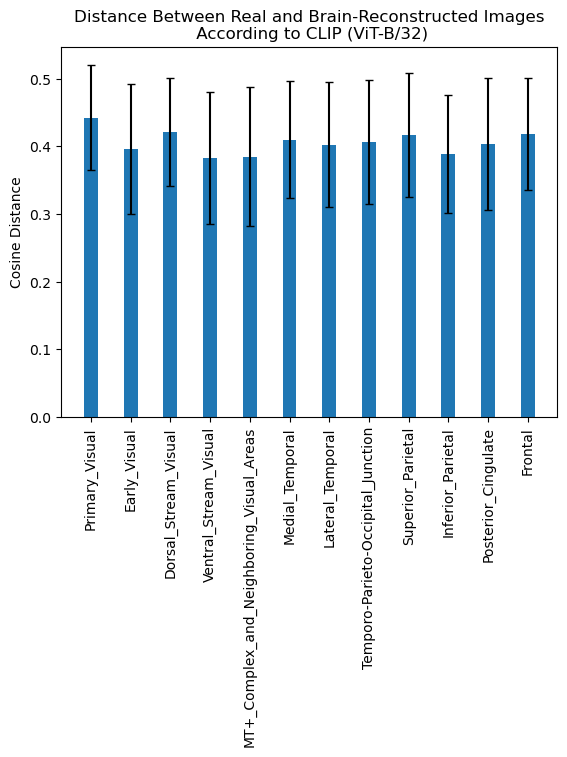

In [43]:
permutation_test = False
cosine_distance = {'mean': [], 'std': []}
for roi_name, roi_data in results.items():
    cosine_distance[roi_name] = {}

    x_recon = roi_data['x_recon']
    x_stim = x[roi_data['stimulus_ids']]
    if permutation_test:
        ids = np.arange(x_stim.shape[0])
        np.random.shuffle(ids)
        x_stim = x_stim[ids]
    distance = 1. - (x_recon * x_stim[:, None]).sum(axis=-1)
    
    cosine_distance['mean'].append(distance.mean())
    cosine_distance['std'].append(distance.std())

bar_pos = np.arange(12)
width = 0.35

fig, ax = plt.subplots()
rects = ax.bar(bar_pos, cosine_distance['mean'], 
                width, yerr=cosine_distance['std'],
                capsize=3)

ax.set_ylabel('Cosine Distance')
ax.set_title('Distance Between Real and Brain-Reconstructed Images\n According to CLIP (ViT-B/32)')
ax.set_xticks(bar_pos, rois, rotation=90,)
#ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

#fig.tight_layout()

plt.show()

In [145]:
# Evaluate mturk batch

model_name = 'clip-vit-large-patch14-text'
group_name = 'group-5'
run_name = 'run-003'
#subjects = [f'subj0{i}' for i in range(1, 9)]
subjects = ['subj05', 'subj08']
batch_name = 'batch-1'
task_version = 'version-2'

results = {}
ranks = {}
for subject in subjects:
    print(subject)
    
    reconstructions_path = nsd_path / f'derivatives/reconstructions/{model_name}/{group_name}/{run_name}/{subject}/'
    with open(reconstructions_path / f'task2_{task_version}_{batch_name}_results.txt') as f:
        task2_results = json.loads(f.read())
    with open(reconstructions_path / f'task3_{task_version}_{batch_name}_results.txt') as f:
        task3_results = json.loads(f.read())
        
    with open(reconstructions_path / f'task_{task_version}_info.json') as f:
        task_info = json.loads(f.read())
    
    task2_results = np.array([[int(ans) for ans in assignment] for assignment in task2_results])
    t3_results = []
    for task, tinfo in zip(task3_results, task_info):
        t3_assignment = []
        for ans in task:
            found = False
            for i, option in enumerate(tinfo):
                if option['caption'].replace("'", "").replace('"', "") == ans:
                    t3_assignment.append(i)
                    found = True
                    break
            if not found:
                print('no answer found...', ans, tinfo)
        t3_results.append(t3_assignment)
            
    task3_results = np.array(t3_results)
    
    task2_results = stats.mode(task2_results, axis=1).mode[:, 0]
    task3_results = stats.mode(task3_results, axis=1).mode[:, 0]
    
    option_k = np.array([[option['k'] for option in tinfo] for tinfo in task_info])
    option_rank = np.argsort(option_k, axis=1)
    N = option_rank.shape[0]
    
    task2_rank = option_rank[np.arange(N), task2_results]
    task3_rank = option_rank[np.arange(N), task3_results]
    
    ranks[subject] = {'task2': task2_rank, 'task3': task3_rank}
    
    results[subject] = {
        'task2': [(task2_rank <= i).mean() for i in range(4)],
        'task3': [(task3_rank <= i).mean() for i in range(4)]
    }
    
    #print(task2_results)
    #print(task3_results)
    #print(task_info)
    #print(len(task2_results), len(task3_results), len(task_info))

subj05
subj08


C:\Users\Cefir\AppData\Local\Temp\ipykernel_20276\2532530632.py:42: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  task2_results = stats.mode(task2_results, axis=1).mode[:, 0]
C:\Users\Cefir\AppData\Local\Temp\ipykernel_20276\2532530632.py:43: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False 

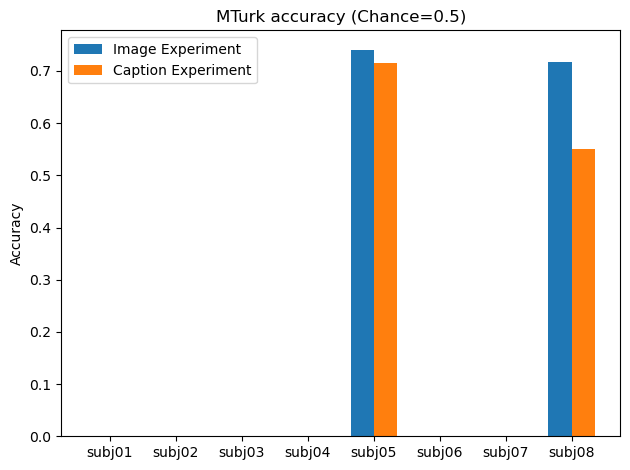

In [115]:
bar_pos = np.arange(8)
width = 0.35
i = 0

subjects = [f'subj0{i}' for i in range(1, 9)]

fig, ax = plt.subplots()
rects1 = ax.bar(bar_pos - width/2, [results[subject]['task2'][i] if subject in results else 0. for subject in subjects], 
                width, label='Image Experiment', capsize=3)
rects2 = ax.bar(bar_pos + width/2, [results[subject]['task3'][i] if subject in results else 0. for subject in subjects], 
                width, label='Caption Experiment', capsize=3)

ax.set_ylabel('Accuracy')
ax.set_title(f'MTurk accuracy (Chance=0.5)')
ax.set_xticks(bar_pos, subjects)
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [146]:
# Get worker data

model_name = 'clip-vit-large-patch14-text'
group_name = 'group-5'
run_name = 'run-003'
#subjects = [f'subj0{i}' for i in range(1, 9)]
subjects = ['subj05', 'subj08']
batch_name = 'batch-1'
tasks = ['task2', 'task3']
task_version = 'version-2'

worker_results = {task: {'workers': {}} for task in tasks}
for subject in subjects:
    print(subject)
    reconstructions_path = nsd_path / f'derivatives/reconstructions/{model_name}/{group_name}/{run_name}/{subject}/'
    
    for task in tasks:
        with open(reconstructions_path / f'{task}_{task_version}_{batch_name}_workers.txt') as f:
            workers = json.loads(f.read())
        for i, assignment in enumerate(workers):
            for worker in assignment:
                worker_id = worker['WorkerId']

                if worker_id not in worker_results[task]['workers']:
                    worker_results[task]['workers'][worker_id] = {'time': [], 'rank': []}

                worker_results[task]['workers'][worker_id]['time'].append(worker['Time'])
                worker_results[task]['workers'][worker_id]['rank'].append(ranks[subject][task][i])
            
    

subj05
subj08


[('A1NF6PELRKACS9',
  {'time': [93.0,
    99.0,
    48.0,
    51.0,
    72.0,
    81.0,
    53.0,
    17.0,
    14.0,
    103.0,
    57.0,
    81.0,
    69.0,
    75.0,
    49.0,
    63.0,
    49.0,
    52.0,
    51.0,
    70.0,
    92.0,
    71.0,
    77.0,
    64.0,
    84.0,
    62.0,
    97.0,
    115.0,
    117.0,
    48.0,
    49.0,
    50.0,
    89.0,
    54.0,
    52.0,
    91.0,
    55.0,
    85.0,
    48.0,
    66.0,
    75.0,
    78.0,
    60.0,
    124.0,
    59.0,
    57.0,
    47.0,
    12.0,
    50.0,
    48.0,
    73.0,
    48.0,
    50.0,
    140.0,
    52.0,
    58.0,
    87.0,
    22.0,
    47.0,
    77.0,
    48.0,
    71.0,
    71.0,
    92.0,
    53.0,
    88.0,
    73.0,
    112.0,
    53.0,
    128.0,
    57.0,
    87.0,
    78.0,
    53.0,
    76.0,
    141.0],
   'rank': [0,
    0,
    1,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    1,
    1,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    0,

task2
worker_id='A1YSYI926BBOHW', num_responses=150, average_time=20s, top_1_accuracy=0.74
worker_id='A264NN7JBX4UDQ', num_responses=143, average_time=45s, top_1_accuracy=0.74
worker_id='A3CJVRJ34U70Y9', num_responses=44, average_time=18s, top_1_accuracy=0.75
worker_id='A2KJ983WWTEK4L', num_responses=42, average_time=25s, top_1_accuracy=0.64
worker_id='A1NF6PELRKACS9', num_responses=30, average_time=35s, top_1_accuracy=0.80
worker_id='A9WGDBDXUNLOD', num_responses=27, average_time=16s, top_1_accuracy=0.74
worker_id='A2VMQ3OKPH6O98', num_responses=9, average_time=42s, top_1_accuracy=0.67
worker_id='A3N5P5VO81FIJ6', num_responses=8, average_time=61s, top_1_accuracy=0.75
worker_id='A3N5RTXKN4I723', num_responses=7, average_time=16s, top_1_accuracy=0.43
worker_id='A3760PCQD2MPIO', num_responses=5, average_time=18s, top_1_accuracy=0.20
worker_id='A26399B1QZ7XJJ', num_responses=4, average_time=20s, top_1_accuracy=0.75
worker_id='A36QYJDZBOQ5PQ', num_responses=4, average_time=36s, top_1_accur

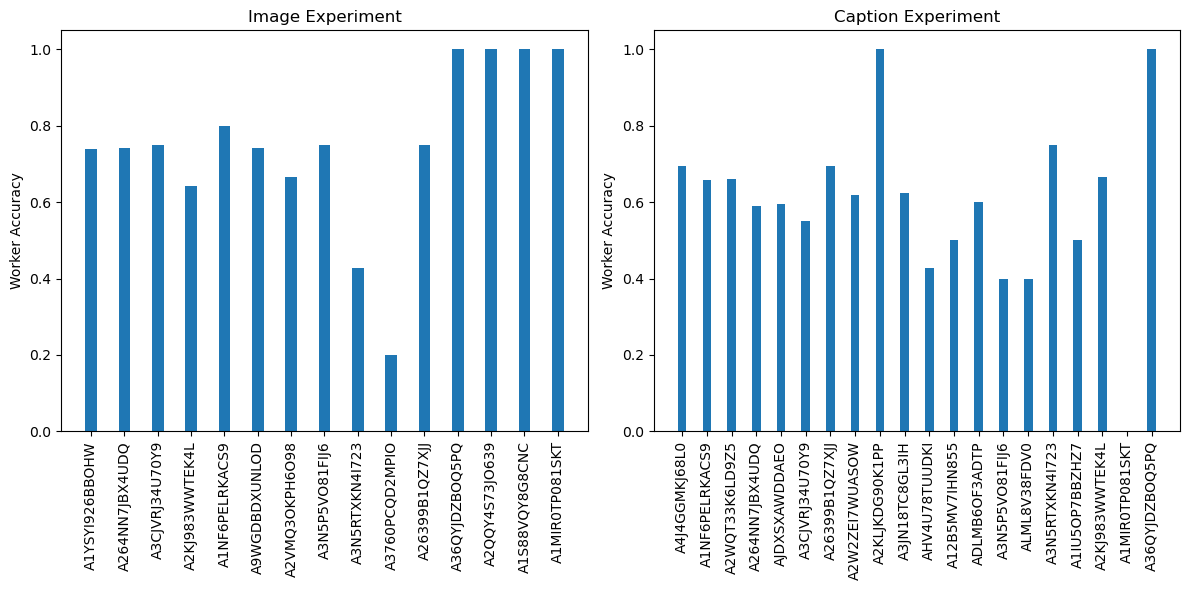

In [147]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

for i, (task, task_workers) in enumerate(worker_results.items()):
    
    workers = list(task_workers['workers'].items())
    workers.sort(key=lambda w: -len(w[1]['time']))
    workers = dict(workers)
    
    width = 0.35    
    labels = list(workers.keys())
    accuracy = [(np.array(worker_data["rank"]) <= 0).mean() for worker_data in workers.values()]
    average_time = [(np.array(worker_data["time"]) <= 0).mean() for worker_data in workers.values()]
    bar_pos = np.arange(len(labels))
    
    rects1 = ax[i].bar(bar_pos, accuracy, width)

    ax[i].set_ylabel('Worker Accuracy')
    ax[i].set_title('Image Experiment' if task == 'task2' else 'Caption Experiment')
    ax[i].set_xticks(bar_pos, labels, rotation=90)

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    print(task)
    for worker_id, worker_data in workers.items():
        num_responses = len(worker_data["time"])
        average_time = np.array(worker_data["time"]).mean()
        top_1_accuracy = (np.array(worker_data["rank"]) <= 0).mean()
        print(f'{worker_id=}, {num_responses=}, {average_time=:.0f}s, {top_1_accuracy=:.2f}')
plt.show()

In [85]:
reconstructions_path = nsd_path / f'derivatives/reconstructions/{model_name}/{group_name}/{run_name}/{subject}'
out_path = reconstructions_path / 'comparisons'
out_path.mkdir(exist_ok=True, parents=True)

image_file_names = [p for p in (reconstructions_path / 'Frontal/images').iterdir() if p.name != 'desktop.ini']
reconstruction_files.sort(key=get_stim_id)
stimulus_ids = np.array([get_stim_id(p) for p in reconstruction_files])
unique_stimulus_ids = np.unique(stimulus_ids)

for stimulus_id in unique_stimulus_ids:
    stimulus_image_file_names = [n.name for n in image_file_names if f'stim-{stimulus_id}' in n.name]
    np.array(Image.open(reconstructions_path / f'derivatives/stimulus_images/{stimulus_id}.png'))
    images = []
    for roi in rois:
        images.append(np.concatenate(
            [np.array(Image.open(reconstructions_path / f'{roi}/images/{image_file_name}')) 
             for image_file_name in stimulus_image_file_names],
            axis=1
        ))
    image = np.concatenate(images, axis=0)
    print(image.shape)
    Image.fromarray(image).save(out_path / f'stim-{stimulus_id}.png')
    

(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1536, 3)
(6144, 1

In [78]:
image_file_names

[WindowsPath('D:/Datasets/NSD/derivatives/reconstructions/clip-vit-large-patch14-text/group-6/run-005/subj01/Frontal/images/image-1001_stim-50755_seed-0_v-0.png'),
 WindowsPath('D:/Datasets/NSD/derivatives/reconstructions/clip-vit-large-patch14-text/group-6/run-005/subj01/Frontal/images/image-1010_stim-28349_seed-0_v-0.png'),
 WindowsPath('D:/Datasets/NSD/derivatives/reconstructions/clip-vit-large-patch14-text/group-6/run-005/subj01/Frontal/images/image-1021_stim-57553_seed-0_v-0.png'),
 WindowsPath('D:/Datasets/NSD/derivatives/reconstructions/clip-vit-large-patch14-text/group-6/run-005/subj01/Frontal/images/image-1034_stim-22879_seed-0_v-0.png'),
 WindowsPath('D:/Datasets/NSD/derivatives/reconstructions/clip-vit-large-patch14-text/group-6/run-005/subj01/Frontal/images/image-1037_stim-28349_seed-0_v-0.png'),
 WindowsPath('D:/Datasets/NSD/derivatives/reconstructions/clip-vit-large-patch14-text/group-6/run-005/subj01/Frontal/images/image-1048_stim-57553_seed-0_v-0.png'),
 WindowsPath('D: